# PROJECT PENGOLAHAN CITRA DIGITAL
---
# Klasifikasi Jenis Serat Kayu Nantu, Palapi, dan Uru Menggunakan GLCM
---
## Disusun Oleh :

  - **KAMILIA ROSADA:** (F1D02310063)
  - **SYA'BANUL MUKARAM:** (F1D02310092)
  - **WADIS FREANDLY:** (F1D02310094)
  - **LALU MUHAMMAD RIZALDI KURNIAWAN:** (F1D02310120)


# Latar Belakang

Proses identifikasi jenis kayu sering kali dilakukan secara manual berdasarkan pengamatan visual terhadap pola serat, warna, dan tekstur permukaan. Namun, metode ini bersifat subjektif dan rentan terhadap kesalahan, terutama ketika jenis kayu memiliki pola serat yang mirip, seperti pada kayu Nantu, Palapi, dan Uru. Ketiga jenis kayu ini banyak digunakan dalam industri lokal, namun sulit dibedakan tanpa keahlian khusus, sehingga dapat menghambat efisiensi produksi atau menyebabkan salah penggunaan material.

Untuk mengatasi hal tersebut, dibutuhkan sistem klasifikasi otomatis berbasis pengolahan citra digital yang mampu mengenali jenis serat kayu secara akurat dan konsisten. Salah satu metode yang efektif untuk mengidentifikasi ciri tekstur pada citra serat kayu adalah Gray Level Co-occurrence Matrix (GLCM). GLCM mampu menggambarkan pola keterhubungan antar piksel pada citra grayscale sehingga menghasilkan fitur tekstur seperti contrast, correlation, homogeneity, dan energy.

Dalam proyek ini, kami menggunakan dataset gambar serat kayu Nantu, Palapi, dan Uru yang diperoleh dari Kaggle untuk membangun sistem klasifikasi berbasis GLCM. Citra-citra tersebut diproses melalui tahapan grayscale, ekstraksi fitur tekstur menggunakan GLCM, dan klasifikasi menggunakan algoritma machine learning seperti K-Nearest Neighbors (KNN), Support Vector Machine (SVM), dan Random Forest. Dengan sistem ini, diharapkan proses identifikasi jenis kayu dapat dilakukan secara lebih cepat, akurat, dan mendukung pengambilan keputusan dalam pengelolaan bahan kayu secara efisien.

# Import Library

Dalam proyek klasifikasi jenis serat kayu Nantu, Palapi, dan Uru menggunakan GLCM, library os dan cv2 digunakan untuk membaca dan mengolah gambar grayscale dari folder masing-masing jenis kayu, sedangkan numpy dan pandas membantu dalam mengubah gambar menjadi array numerik dan menyusun dataset fitur. Ekstraksi fitur tekstur dilakukan menggunakan `graycomatrix` dan `graycoprops` dari `skimage.feature` untuk memperoleh nilai-nilai seperti contrast, homogeneity, energy, dan correlation, serta entropy dari scipy.stats untuk mengukur keacakan citra. Dataset hasil ekstraksi kemudian dibagi menjadi data latih dan uji menggunakan train_test_split, lalu diklasifikasikan dengan algoritma seperti Random Forest, SVM, dan KNN. Evaluasi performa model dilakukan menggunakan metrik seperti akurasi, precision, recall, F1-score, dan confusion matrix melalui sklearn.metrics, sedangkan hasil klasifikasi divisualisasikan dengan bantuan matplotlib.pyplot, ConfusionMatrixDisplay, dan seaborn agar lebih mudah dianalisis secara visual.

In [20]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# Load gambar

Kode tersebut digunakan untuk membaca dataset citra serat kayu dari direktori bernama serat_kayu, yang di dalamnya terdapat subfolder berdasarkan nama kelas (misalnya Nantu, Palapi, Uru). Program akan menjelajahi setiap subfolder, kemudian membaca setiap gambar di dalamnya. Gambar yang dibaca kemudian diubah menjadi format grayscale menggunakan OpenCV (cv.cvtColor) agar hanya menyimpan informasi intensitas piksel, yang dibutuhkan untuk ekstraksi fitur tekstur. Setiap gambar juga dikonversi ke tipe data uint8 agar sesuai dengan format input yang dibutuhkan metode GLCM.

Setelah citra diproses, gambar tersebut disimpan ke dalam list data, label kelasnya (berdasarkan nama folder) disimpan ke list labels, dan nama file asli citra disimpan ke list file_name untuk referensi jika diperlukan. Setelah semua gambar dibaca, list data dan labels diubah menjadi array NumPy agar bisa lebih mudah digunakan dalam proses pelatihan model machine learning, karena banyak fungsi dari scikit-learn dan NumPy memerlukan data dalam bentuk array. Dengan demikian, kode ini menjadi tahap awal penting dalam proses klasifikasi citra serat kayu karena mempersiapkan data mentah menjadi siap pakai untuk ekstraksi fitur dan klasifikasi.

In [21]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("serat_kayu\\"):
    sub_folder_files = os.listdir(os.path.join("serat_kayu\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("serat_kayu\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


# Fungsi Preprocessing

Pada tahapan preprocessing ini, digunakan beberapa metode untuk mempersiapkan citra sebelum analisis lebih lanjut. Proses dimulai dengan resize untuk menyesuaikan ukuran gambar ke dimensi tertentu, dilanjutkan dengan konversi ke grayscale agar lebih sederhana dalam pemrosesan. Setelah itu, dilakukan histogram equalization guna meningkatkan kontras citra. Untuk menyoroti detail batas objek, dilakukan edge detection, dan untuk manipulasi bentuk objek dalam citra digunakan operasi dilasi dan erosi. Terakhir, diterapkan median filter sebagai langkah reduksi noise untuk menghilangkan gangguan piksel acak. Seluruh rangkaian ini membentuk tahapan awal yang penting dalam pemrosesan citra digital.

In [ ]:
def resize(image, target_size):
    target_h, target_w = target_size
    src_h, src_w = image.shape
    resized = np.zeros((target_h, target_w), dtype=np.uint8)

    for i in range(target_h):
        for j in range(target_w):
            src_x = int(i * src_h / target_h)
            src_y = int(j * src_w / target_w)
            resized[i, j] = image[src_x, src_y]

    return resized

Fungsi resize digunakan untuk mengubah ukuran citra ke dimensi yang diinginkan `target_size`. Fungsi ini bekerja dengan cara menghitung posisi piksel sumber `src_x`dan `src_y` berdasarkan skala dari ukuran asli `src_h` dan `src_w` ke ukuran target `target_h` dan `target_w`. Nilai piksel dari posisi tersebut kemudian disalin ke posisi baru dalam citra hasil `resized`. Metode ini dikenal sebagai `nearest neighbor interpolation`, karena mengambil nilai piksel terdekat tanpa melakukan perataan atau interpolasi lanjutan. Hasilnya adalah citra baru dengan ukuran yang sudah diubah sesuai target.

In [ ]:
def konversi_grayscale(image):
    if len(image.shape) == 3:
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return gray.astype(np.uint8)
    else:
        return image 

Fungsi `konversi_grayscale` digunakan untuk mengubah citra berwarna menjadi citra grayscale. Fungsi ini memeriksa apakah bentuk citra memiliki tiga dimensi `image.shape' == 3`, yang berarti citra tersebut berformat RGB. Jika ya, maka masing-masing saluran warna — merah `r`, hijau `g`, dan biru `b` — diambil dari citra dan dikombinasikan menggunakan rumus 0.299 * r + 0.587 * g + 0.114 * b. Rumus ini mencerminkan persepsi mata manusia terhadap intensitas cahaya dari tiap warna. Hasilnya adalah citra grayscale yang kemudian dikonversi ke tipe data uint8. Jika citra sudah grayscale, maka fungsi langsung mengembalikan citra tersebut tanpa diubah.

In [ ]:
def equalization(image):
    histogram = np.zeros(256, dtype=int)
    h, w = image.shape

    for i in range(h):
        for j in range(w):
            histogram[image[i, j]] += 1

    cdf = np.cumsum(histogram)
    cdf_min = np.min(cdf[np.nonzero(cdf)])
    total_pixels = h * w
    equalized = np.round((cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255)
    equalized = np.clip(equalized, 0, 255).astype(np.uint8)

    return equalized

Fungsi `equalization` digunakan untuk melakukan histogram equalization pada citra grayscale. Pertama, fungsi membuat array histogram berukuran 256 untuk menghitung frekuensi kemunculan tiap nilai intensitas piksel. Ukuran citra disimpan dalam h dan w. Kemudian, fungsi menghitung cdf (cumulative distribution function) dari histogram, dan mengambil nilai minimum pertama yang tidak nol atau cdf_min. Nilai cdf ini digunakan untuk menghitung nilai intensitas baru bagi setiap piksel berdasarkan rumus normalisasi yaitu (cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255. Hasilnya dipotong agar tetap dalam rentang 0–255 dengan `np.clip` dan dikonversi ke tipe uint8. Citra hasilnya memiliki distribusi intensitas yang lebih merata sehingga kontrasnya meningkat.

In [ ]:
def edge_detection(image):
    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]])
    kernel_y = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]])

    h, w = image.shape
    result = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            gx = np.sum(region * kernel_x)
            gy = np.sum(region * kernel_y)
            result[i, j] = np.clip(np.sqrt(gx**2 + gy**2), 0, 255)

    return result.astype(np.uint8)

Fungsi `edge_detection` digunakan untuk mendeteksi tepi pada citra grayscale menggunakan dua kernel, yaitu kernel_x dan kernel_y, yang masing-masing menangkap perubahan intensitas secara horizontal dan vertikal. Citra diproses dengan padding menggunakan `np.pad` agar konvolusi bisa dilakukan di seluruh area gambar. Untuk setiap piksel, diambil region berukuran 3x3, lalu dihitung nilai gradien gx dan gy dengan menjumlahkan hasil perkalian region dan masing-masing kernel. Nilai akhir pada piksel dihitung dengan rumus `np.sqrt(gx**2 + gy**2)`, lalu diklip ke rentang 0–255 menggunakan `np.clip` dan dikonversi ke uint8. Hasil akhirnya adalah citra yang menyoroti area dengan perubahan intensitas tinggi, yaitu bagian tepi objek.

In [ ]:
def dilasi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.max(region * kernel)

    return output

Fungsi `dilasi` melakukan operasi dilasi pada citra biner atau grayscale dengan menggunakan kernel 3x3 yang berisi nilai satu. Citra terlebih dahulu diberi padding agar proses dilasi bisa diterapkan pada seluruh piksel, termasuk tepi. Untuk setiap piksel, diambil region `3x3` di sekitar piksel tersebut, lalu nilai maksimum dari region tersebut dihitung dan disimpan ke posisi yang sesuai pada citra output. Operasi ini memperbesar area objek terang dengan menambahkan piksel di sekitar batas objek, sehingga tepi objek menjadi lebih tebal atau melebar.

In [ ]:
def erosi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.min(region * kernel)

    return output

Fungsi `erosi` melakukan operasi erosi pada citra biner atau grayscale menggunakan kernel 3x3 yang berisi nilai satu. Citra diberi padding terlebih dahulu agar operasi dapat mencakup seluruh piksel, termasuk bagian tepi. Untuk setiap piksel, diambil region berukuran 3x3, lalu dihitung nilai minimum dari hasil perkalian region dan kernel. Nilai minimum tersebut disimpan sebagai nilai piksel pada citra output. Operasi ini mengecilkan area objek terang dengan menghapus piksel di sekitar batasnya, sehingga objek tampak lebih tipis atau menyusut.

In [ ]:
def reduce_noise(image, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='edge')
    h, w = image.shape
    output = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kernel_size, j:j+kernel_size].flatten()
            sorted_region = np.sort(region)
            median = sorted_region[len(sorted_region) // 2]
            output[i, j] = median
    return output.astype(np.uint8)

Fungsi `reduce_noise` digunakan untuk mengurangi noise pada citra grayscale menggunakan metode median filter dengan ukuran kernel yang dapat ditentukan, default-nya adalah 3. Citra diberi padding dengan metode edge agar ukuran tetap sama setelah proses filter. Untuk setiap piksel, diambil region seukuran kernel di sekitarnya, lalu nilai-nilai dalam region diurutkan menggunakan `np.sort`. Nilai median dari region tersebut diambil dan disimpan sebagai nilai piksel pada citra output. Pendekatan ini efektif dalam menghilangkan noise impuls seperti salt-and-pepper tanpa mengaburkan tepi objek secara signifikan.

# Preprocessing

In [ ]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i] # ambil data gambar

    # 1. Resize
    img = resize(img, (256,256))

    # 2. Konversi ke grayscale
    img = konversi_grayscale(img)

    # 3. Histogram Equalization untuk meningkatkan kontras
    img = equalization(img)

    # 4. Noise reduction
    img = reduce_noise(img)

    # 5. Erosi
    img = erosi(img)

    # 6. Dilasi
    img = dilasi(img)

    # Simpan hasil akhir preprocessing
    dataPreprocessed.append(img)


kode tersebut melakukan rangkaian preprocessing pada kumpulan data citra yang disimpan dalam data. Setiap citra diproses melalui beberapa tahap, dimulai dari resize ke ukuran (256, 256), lalu dikonversi ke citra grayscale menggunakan konversi_grayscale. Setelah itu, kontras citra ditingkatkan melalui equalization, kemudian noise dikurangi dengan reduce_noise. Selanjutnya, dilakukan operasi morfologi erosi untuk menipiskan objek, diikuti oleh dilasi untuk menebalkan kembali objek. Hasil akhir dari setiap citra yang telah diproses disimpan dalam list dataPreprocessed. Proses ini memastikan bahwa semua citra memiliki ukuran dan kualitas yang seragam sebelum digunakan dalam tahap selanjutnya, seperti pelatihan model atau analisis citra.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Kode dibawah berfungsi untuk menampilkan visualisasi 5 gambar pertama dari setiap kelas atau label yang ada di dataset yang sudah melalui preprocessing. Pertama, kode mengambil daftar label unik dari variabel labels, yang merepresentasikan jenis-jenis serat kayu yaitu Nantu, Palapi, Uru. Kemudian, dibuat figure atau area gambar dengan ukuran yang disesuaikan agar semua gambar dapat terlihat dengan jelas.

Setiap baris pada tampilan ini mewakili satu label, dan setiap baris akan menampilkan 5 gambar pertama yang termasuk ke dalam label tersebut. Kode menggunakan plt.subplot untuk mengatur posisi gambar secara grid (baris dan kolom), sehingga gambar-gambar tersebut tertata rapi. Fungsi imshow digunakan untuk menampilkan gambar yang sudah diproses sebelumnya yaitu `dataPreprocessed`, dengan warna grayscale `cmap='gray'`.

Setiap gambar juga diberi judul yang menunjukkan label (jenis kayu) dan nama file gambar (file_name[idx]) agar kamu mudah mengenali gambar tersebut. Setelah semua gambar siap, fungsi `plt.tight_layout()` memastikan tata letak gambar tidak saling tumpang tindih, dan `plt.show()` menampilkan semua gambar tersebut secara keseluruhan di jendela visualisasi. Jadi kamu bisa melihat bagaimana bentuk dan tekstur serat kayu dari masing-masing kelas sebelum proses selanjutnya.

Ctra hasil dari preprocessing tersebut menunjukkan ketiga jenis kayu, yaitu Nantu, Palapi, dan Uru, memiliki karakteristik tekstur yang berbeda meskipun secara visual tampak mirip. Kayu Nantu umumnya memiliki pola serat yang kasar dan padat, dengan garis-garis tebal yang tidak terlalu teratur serta permukaan yang tampak berbintik atau granuler. Berbeda dengan itu, kayu Palapi menunjukkan pola serat yang lebih halus dan teratur, ditandai dengan garis-garis lurus panjang yang sejajar dan seragam, sehingga memberi kesan lebih rapi. Sementara itu, kayu Uru memiliki tekstur yang lebih lembut dengan pola yang cenderung acak, menyerupai kabut atau noise halus yang tersebar merata, tanpa arah serat yang dominan. 

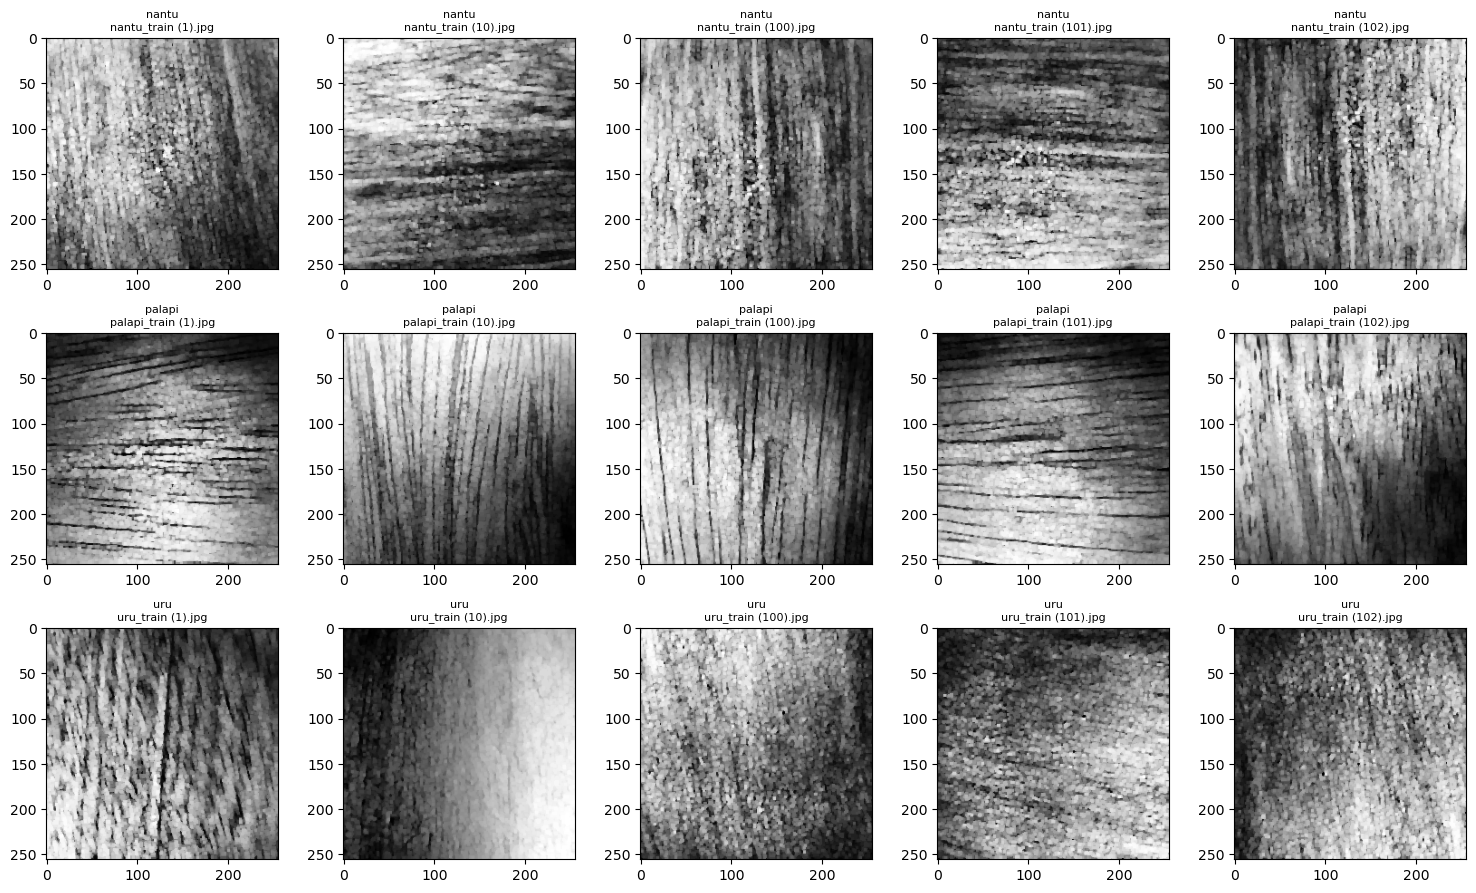

In [24]:
# Visualisasi 5 citra pertama dari setiap label
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 3 * len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 index pertama dari label tsb
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i * 5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label}\n{file_name[idx]}", fontsize=8)

plt.tight_layout()
plt.show()

# Ekstraksi GLCM

In [25]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi `glcm` digunakan untuk menghasilkan matriks ko-occurrence tingkat abu-abu (GLCM) dari citra grayscale, yang berguna dalam ekstraksi fitur tekstur. Fungsi ini menerima parameter image dan derajat, di mana derajat menentukan arah hubungan antar piksel (0, 45, 90, atau 135 derajat). Nilai derajat tersebut dikonversi menjadi sudut radian dan digunakan oleh fungsi graycomatrix dari pustaka skimage.feature. Fungsi graycomatrix membentuk GLCM berdasarkan jarak antar piksel yaitu 1 piksel, dengan opsi `symmetric=True` agar matriks bersifat simetris, dan `normed=True` agar nilai-nilainya ternormalisasi. Hasil akhirnya adalah matriks GLCM yang dapat digunakan untuk menghitung berbagai fitur tekstur seperti kontras, homogeneity, energy, dan correlation.

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `correlation` digunakan untuk menghitung nilai korelasi dari matriks GLCM (Gray Level Co-occurrence Matrix) yang telah dibentuk sebelumnya. Fungsi ini memanfaatkan `graycoprops` dari pustaka skimage.feature dengan parameter `correlation`, yang mengukur hubungan linier antara piksel dalam pasangan pada GLCM. Nilai yang dikembalikan adalah elemen pertama dari hasil, yaitu `graycoprops(matriks, 'correlation')[0, 0]`, yang merepresentasikan nilai korelasi untuk arah dan jarak yang telah ditentukan saat pembuatan GLCM. Korelasi ini menunjukkan sejauh mana intensitas piksel satu berhubungan dengan intensitas piksel tetangganya dalam pola tekstur citra.

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi ini memanggil graycoprops dengan parameter `dissimilarity` untuk menghitung nilai ketidaksamaan dari sebuah matriks GLCM. Nilai yang diambil adalah elemen pada indeks [0, 0] dari hasil keluaran, yang merupakan representasi dari arah dan jarak yang digunakan saat GLCM dibuat. Fungsi ini tidak melakukan proses tambahan selain memanggil metode yang sudah tersedia dari library. Input yang digunakan harus berupa hasil dari fungsi `graycomatrix`. Nilai akhir yang dikembalikan berupa bilangan float yang menunjukkan tingkat perbedaan antar piksel yang terhubung.

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi ini menghitung nilai `homogenitas` dari sebuah matriks GLCM dengan memanggil fungsi graycoprops dan parameter `homogeneity`. Nilai yang dikembalikan adalah elemen pada indeks [0, 0] dari hasil keluaran fungsi tersebut. Tidak ada perhitungan tambahan di dalam fungsi ini, hanya pemrosesan langsung dari library. Matriks input diasumsikan sebagai hasil pemrosesan dari `graycomatrix` dengan parameter arah dan jarak tertentu. Fungsi ini mengembalikan sebuah nilai float yang mencerminkan sejauh mana nilai piksel dalam matriks saling menyerupai.

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi ini bertugas menghitung nilai kontras dari matriks GLCM menggunakan `graycoprops` dengan parameter `contrast`. Hasil perhitungan diakses pada indeks [0, 0] dari array hasil yang dikembalikan oleh fungsi. Pemrosesan dalam fungsi ini cukup langsung karena tidak ada manipulasi data tambahan sebelum atau sesudah pemanggilan fungsi. Nilai ini berasal dari distribusi pasangan piksel dalam matriks berdasarkan arah dan jarak yang ditentukan. Fungsi mengembalikan satu nilai float yang mencerminkan besarnya perbedaan lokal antar pasangan piksel.

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi ini memanggil `graycoprops` dengan parameter `ASM` untuk menghitung `Angular Second Moment` dari matriks GLCM. Nilai ASM diambil dari elemen indeks [0, 0] dari hasil keluaran. Fungsi ini tidak memiliki proses tambahan selain memanfaatkan output langsung dari library. Nilai ASM sering berkaitan dengan energi tekstur dalam data citra, namun di sini hanya dihitung berdasarkan struktur internal matriks. Matriks input yang diberikan harus hasil dari `graycomatrix`, dan hasil yang dikembalikan berupa nilai float.

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi ini mengambil nilai `energy` dari matriks GLCM melalui pemanggilan graycoprops dengan argumen `energy`. Seperti fungsi lainnya, hanya elemen [0, 0] dari hasil array yang diambil. Fungsi ini bekerja langsung tanpa modifikasi data sebelumnya, sehingga sangat bergantung pada hasil GLCM yang dimasukkan. Nilai energy ini diperoleh sebagai akar kuadrat dari nilai ASM yang sudah dihitung sebelumnya. Hasil yang dikembalikan adalah sebuah angka float yang merepresentasikan kekuatan energi dalam matriks.

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi ini memanfaatkan `entropy` dari pustaka `scipy.stats` untuk menghitung nilai entropi dari matriks GLCM. Matriks terlebih dahulu diubah menjadi satu dimensi menggunakan `.ravel()` sebelum diproses. Tidak dilakukan normalisasi secara eksplisit di dalam fungsi, sehingga nilai yang dihitung berasal langsung dari distribusi nilai dalam matriks. Perhitungan entropi ini dilakukan terhadap semua elemen yang ada di dalam array hasil perataan. Fungsi mengembalikan satu nilai float sebagai hasil akhir dari perhitungan entropi tersebut.

In [27]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

kode ini membuat empat list kosong yang masing-masing akan menyimpan hasil matriks GLCM untuk derajat 0, 45, 90, dan 135 derajat. Kemudian dilakukan iterasi sepanjang dataPreprocessed, yaitu daftar citra yang sudah melalui proses pra-pemrosesan sebelumnya. Untuk setiap citra dalam list tersebut, fungsi `glcm()` dipanggil empat kali dengan parameter derajat yang berbeda-beda, yaitu 0, 45, 90, dan 135, yang mewakili arah hubungan antar piksel dalam pembuatan matriks GLCM. Hasil dari masing-masing pemanggilan fungsi disimpan ke dalam list yang sesuai yaitu D0 disimpan ke Derajat0, D45 ke Derajat45, dan seterusnya. Proses ini dilakukan untuk setiap gambar sehingga semua citra yang sudah diproses memiliki empat versi matriks GLCM yang mewakili arah hubungan piksel berbeda.

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode ini mendeklarasikan `28 list` kosong yang masing-masing disiapkan untuk menyimpan nilai fitur tekstur yang dihitung dari matriks GLCM pada empat arah berbeda yaitu 0, 45, 90, dan 135 derajat. Setiap kelompok fitur seperti `Kontras`, `Dissimilarity`, `Homogenity`, `Entropy`, `ASM`, `Energy`, dan `Correlation` memiliki empat list masing-masing yang menampung hasil perhitungan berdasarkan arah tersebut. Misalnya, `Kontras0` akan menampung nilai kontras dari GLCM derajat 0 untuk seluruh citra, sementara `Kontras45` menampung dari derajat 45, dan seterusnya. Struktur ini digunakan agar setiap fitur tekstur dari tiap arah bisa dianalisis secara terpisah dan lebih mudah dikelola saat proses ekstraksi ciri dilakukan pada setiap gambar yang telah dipreproses.

In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

kode ini melakukan proses ekstraksi fitur correlation dari setiap matriks GLCM yang telah dihitung sebelumnya untuk masing-masing arah. Dalam perulangan for, diakses setiap elemen GLCM dari arah 0, 45, 90, dan 135 derajat dengan menggunakan indeks i. Setiap matriks GLCM tersebut kemudian diproses menggunakan fungsi `correlation()` untuk memperoleh nilai korelasi dari hubungan antar piksel pada arah tertentu. Hasilnya disimpan ke dalam list yang sesuai yaitu `correlation0` untuk arah 0 derajat, `correlation45` untuk 45 derajat, dan seterusnya. Proses ini memastikan bahwa untuk setiap gambar yang telah dipreproses, nilai korelasi berdasarkan arah dapat disimpan dan dianalisis lebih lanjut.

In [ ]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini melakukan ekstraksi fitur contrast dari setiap matriks GLCM yang telah diperoleh untuk arah 0, 45, 90, dan 135 derajat. Melalui perulangan for, program mengambil masing-masing GLCM dari setiap arah untuk citra ke-i dan menghitung nilai kontrasnya menggunakan fungsi `contrast()`. Nilai hasil perhitungan kemudian dimasukkan ke dalam list yang sesuai seperti `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`. Dengan cara ini, setiap gambar akan memiliki empat nilai kontras berdasarkan arah yang berbeda, yang nantinya bisa digunakan dalam proses analisis tekstur atau klasifikasi citra.

In [ ]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini digunakan untuk menghitung nilai `dissimilarity` dari setiap matriks GLCM yang mewakili arah 0, 45, 90, dan 135 derajat. Dalam setiap iterasi, GLCM dari masing-masing arah diambil berdasarkan indeks i lalu dihitung tingkat ketidaksamaan antar piksel menggunakan fungsi `dissimilarity()`. Hasil dari perhitungan untuk setiap arah disimpan ke dalam list yang sesuai seperti dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Proses ini dilakukan untuk seluruh gambar dalam dataset agar setiap gambar memiliki informasi tekstur berdasarkan nilai ketidaksamaan piksel dari berbagai arah.

In [ ]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini berfungsi untuk menghitung nilai homogenity dari setiap matriks GLCM hasil ekstraksi arah 0, 45, 90, dan 135 derajat. Pada setiap iterasi, nilai homogenity dihitung dari masing-masing GLCM menggunakan fungsi `homogenity()` yang mengukur tingkat keseragaman nilai piksel dalam tekstur gambar. Nilai hasil penghitungan kemudian dimasukkan ke dalam list yang sesuai dengan arah GLCM-nya, yaitu `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Dengan melakukan ini untuk semua gambar, didapatkan representasi keseragaman tekstur dari berbagai arah untuk keperluan analisis atau klasifikasi selanjutnya.

In [ ]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini melakukan perhitungan nilai `entropy` dari matriks GLCM pada empat arah berbeda: 0, 45, 90, dan 135 derajat, untuk setiap citra hasil preprocessing. Fungsi `entropyGlcm()` digunakan untuk menghitung nilai entropi dari GLCM, yang merepresentasikan tingkat ketidakteraturan atau kompleksitas tekstur gambar. Nilai yang diperoleh dari masing-masing arah disimpan ke dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135` secara berurutan. Proses ini membantu mengumpulkan informasi tekstur dalam bentuk entropi dari setiap citra berdasarkan sudut arah hubungan antar piksel.

In [ ]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini menghitung nilai `ASM (Angular Second Moment)` dari matriks GLCM untuk empat arah: 0, 45, 90, dan 135 derajat, dari setiap citra dalam dataset. Fungsi `ASM()` dipanggil dengan parameter matriks GLCM yang sesuai, lalu hasilnya disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. ASM menggambarkan tingkat keteraturan dan keseragaman tekstur, di mana nilai yang tinggi menunjukkan tekstur yang lebih homogen. Proses ini dilakukan dalam perulangan sebanyak jumlah data citra yang telah diproses sebelumnya.

In [ ]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini digunakan untuk menghitung nilai energy dari setiap matriks GLCM pada empat arah sudut yaitu 0, 45, 90, dan 135 derajat untuk seluruh data citra. Fungsi `energy()` dipanggil masing-masing dengan GLCM dari arah yang sesuai, lalu hasilnya disimpan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Nilai energy ini merepresentasikan tingkat keseragaman atau keteraturan suatu citra. Semakin tinggi nilainya, semakin sedikit variasi dalam tekstur citra. Perulangan dilakukan sebanyak jumlah data citra yang ada di dalam list data.

---
Kode ini membuat sebuah tabel dari hasil ekstraksi fitur tekstur citra menggunakan metode GLCM ke dalam format CSV. Pertama, sebuah dictionary dataTable dibuat dengan pasangan key dan value, yang terdiri dari nama file `Filename`, label kategori `Label`, serta nilai-nilai fitur seperti `Contrast`, `Homogeneity`, `Dissimilarity`, `Entropy`, `ASM`, `Energy`, dan `Correlation` untuk empat arah (0°, 45°, 90°, 135°). Selanjutnya, dictionary tersebut dikonversi menjadi DataFrame menggunakan pandas. Setelah itu, data tersebut disimpan ke dalam file CSV bernama `hasil_ekstraksi_percobaan_3.csv` tanpa menyertakan index. Terakhir, file CSV yang telah dibuat dibaca kembali dan ditampilkan menggunakan `hasilEkstrak`.

In [30]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan_3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nantu_train (1).jpg,nantu,439.078018,567.352111,269.439185,602.110573,0.499461,0.318769,0.534611,0.313481,...,0.006169,0.002520,0.073872,0.050919,0.078541,0.050197,0.920262,0.896853,0.951058,0.890531
1,nantu_train (10).jpg,nantu,186.433793,560.833818,451.318551,537.344391,0.559164,0.332043,0.500723,0.336478,...,0.007731,0.004322,0.097700,0.064971,0.087925,0.065743,0.975464,0.926070,0.940550,0.929167
2,nantu_train (100).jpg,nantu,577.680392,734.679923,299.812240,736.489504,0.498382,0.321911,0.548195,0.319320,...,0.008492,0.003511,0.083840,0.059616,0.092152,0.059253,0.904926,0.878997,0.950758,0.878703
3,nantu_train (101).jpg,nantu,304.580101,750.967659,589.916743,749.384744,0.548309,0.318619,0.493773,0.317654,...,0.006927,0.003486,0.092214,0.059180,0.083227,0.059043,0.949771,0.875864,0.902554,0.876129
4,nantu_train (102).jpg,nantu,592.001608,751.448212,304.106939,751.317586,0.494438,0.318976,0.547768,0.316120,...,0.008489,0.003466,0.083343,0.059244,0.092134,0.058870,0.902252,0.875838,0.949871,0.875863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,uru_train (95).jpg,uru,69.888971,188.914371,158.737914,202.304375,0.549878,0.338292,0.513381,0.335345,...,0.002876,0.001394,0.057311,0.037721,0.053633,0.037334,0.992591,0.979904,0.983136,0.978479
1265,uru_train (96).jpg,uru,159.822656,189.794756,69.789231,202.954787,0.513873,0.337600,0.549809,0.336389,...,0.003299,0.001411,0.053830,0.037749,0.057434,0.037569,0.983053,0.979848,0.992615,0.978450
1266,uru_train (97).jpg,uru,114.206327,142.504975,50.859988,141.261869,0.517375,0.339812,0.554693,0.339765,...,0.002736,0.001163,0.049546,0.034113,0.052305,0.034109,0.988832,0.986046,0.995030,0.986167
1267,uru_train (98).jpg,uru,51.032353,145.605121,117.549617,144.754494,0.554462,0.339408,0.516848,0.340591,...,0.002439,0.001160,0.052229,0.034024,0.049391,0.034064,0.995009,0.985720,0.988488,0.985803


----------
Kode ini digunakan untuk melakukan seleksi fitur berdasarkan nilai korelasi antar fitur numerik yang diekstraksi dari citra. Pertama, `corr()` menghitung matriks korelasi antar kolom pada `hasilEkstrak`, dengan mengecualikan kolom Label dan Filename. Kemudian, dilakukan penyaringan fitur-fitur yang memiliki korelasi sangat tinggi `lebih dari atau sama dengan 0.95` agar tidak ada fitur yang redundan. Proses ini dilakukan dengan menggunakan array boolean columns untuk menandai fitur yang tetap dipertahankan. Fitur-fitur yang lolos seleksi disimpan ke dalam variabel x_new, sedangkan labelnya dipisahkan ke dalam variabel `y`. Terakhir, korelasi antar fitur terpilih divisualisasikan dalam bentuk heatmap menggunakan seaborn dengan ukuran besar (17x17) dan anotasi nilai korelasinya.

<Axes: >

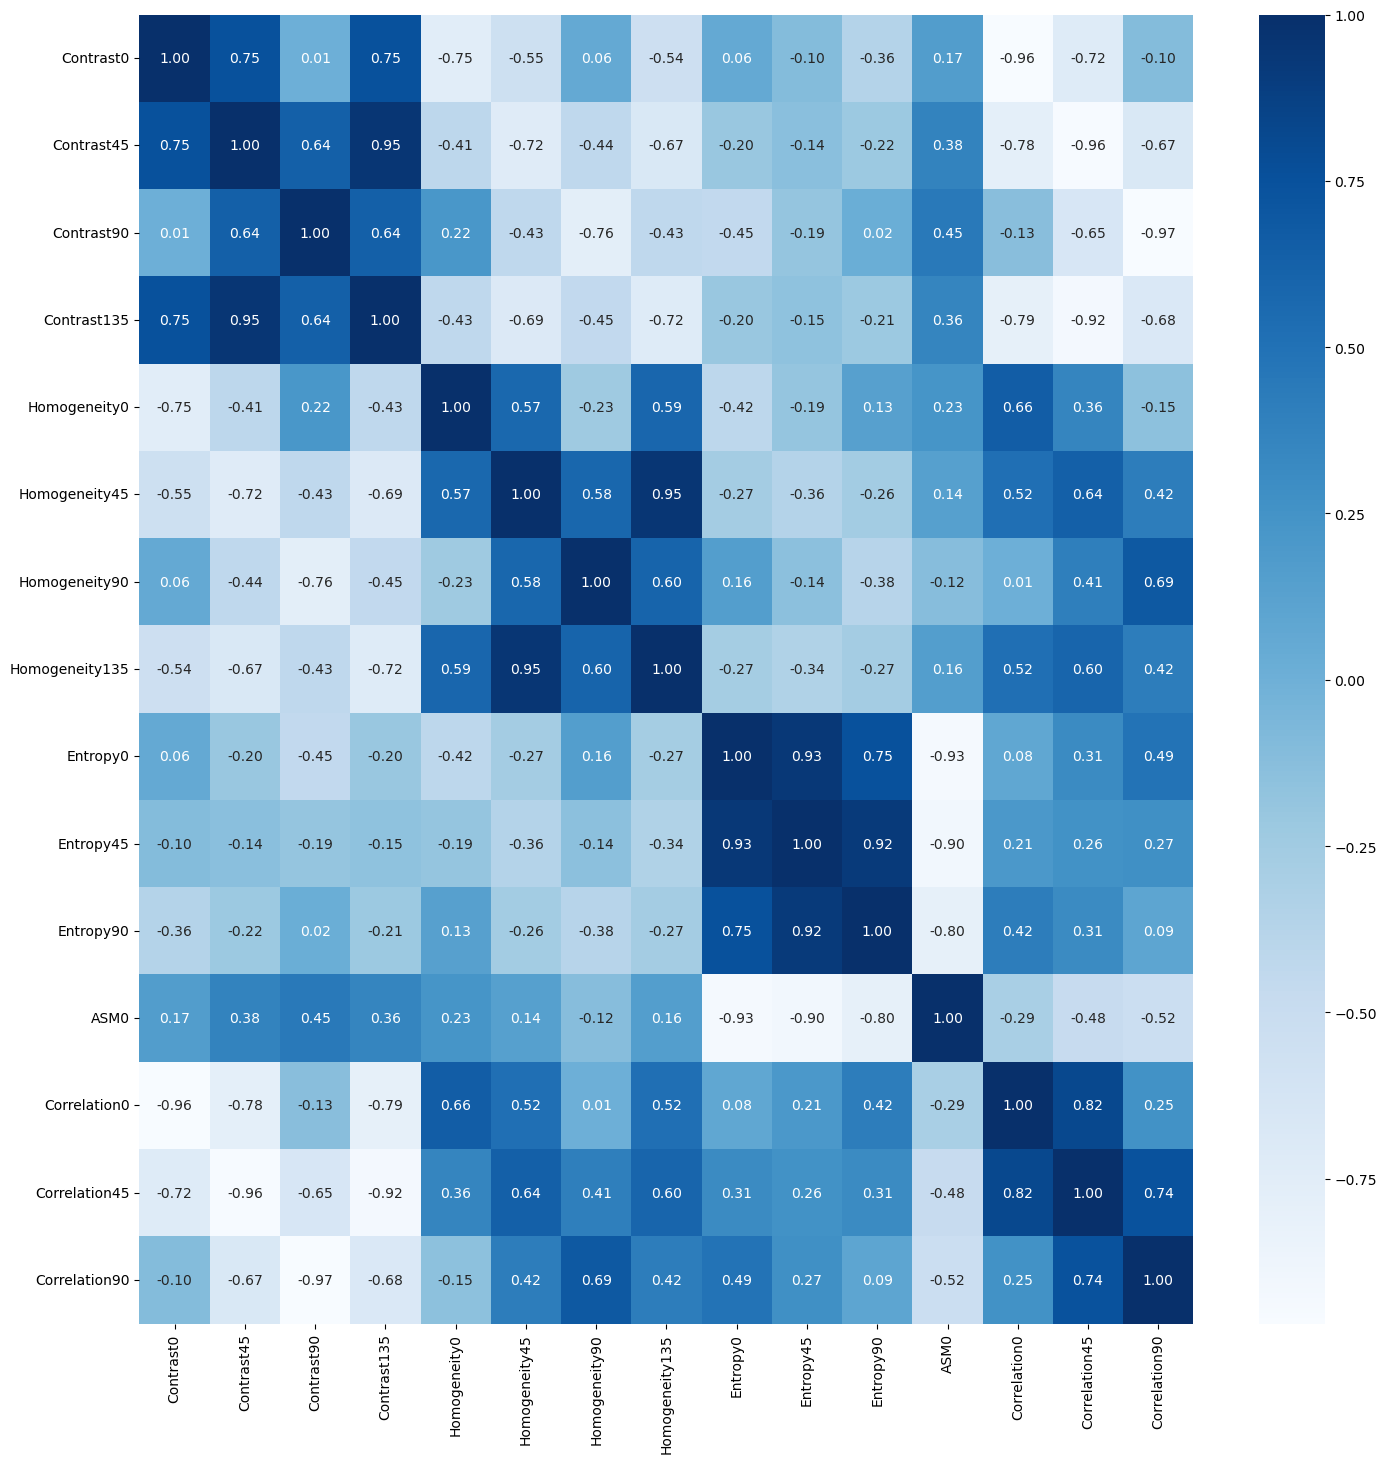

In [31]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting data

In [32]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1015, 15)
(254, 15)


Kode ini digunakan untuk membagi dataset hasil seleksi fitur `x_new` dan labelnya `y` menjadi data pelatihan dan pengujian. Fungsi `train_test_split` dari `sklearn.model_selection` membagi data dengan proporsi yang ditentukan oleh parameter `test_size`. Dalam hal ini, `test_size=0.2` berarti 20% dari data digunakan sebagai data pengujian dan sisanya 80% sebagai data pelatihan. Parameter `random_state=42` digunakan agar pembagian data bersifat konsisten saat dijalankan berulang kali. Setelah pembagian, `X_train` dan `y_train` menyimpan data dan label untuk pelatihan, sedangkan X_test dan y_test untuk pengujian. Fungsi `print()` digunakan untuk menampilkan bentuk yaitu jumlah baris dan kolom dari data pelatihan dan pengujian.

# Normalisasi Fitur

In [33]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini melakukan normalisasi pada data fitur `X_train` dan `X_test` menggunakan metode `mean-std` atau `Z-score` normalization. Langkah pertama menghitung rata-rata yaitu mean dan standar deviasi yaitu std dari data pelatihan `X_train`. Kemudian setiap nilai dalam `X_train` dan `X_test` dikurangi dengan rata-rata tersebut dan dibagi dengan standar deviasi yang sama. Tujuannya adalah untuk membuat setiap fitur memiliki distribusi dengan rata-rata 0 dan deviasi standar 1, yang penting agar algoritma pembelajaran mesin bekerja lebih optimal. Perlu diperhatikan bahwa normalisasi `X_test` juga menggunakan nilai rata-rata dan standar deviasi dari `X_train`, bukan dari `X_test`, agar tidak terjadi kebocoran data yaitu data leakage dari data pengujian.

# Modelling

In [34]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini mendefinisikan fungsi dan tiga model klasifikasi yang akan digunakan. Fungsi `generateClassificationReport` menerima label sebenarnya `y_true` dan label prediksi `y_pred` sebagai argumen. Fungsi ini menampilkan metrik evaluasi berupa classification report, confusion matrix, dan nilai akurasi menggunakan fungsi-fungsi dari library `sklearn.metrics`. Selanjutnya, tiga algoritma pembelajaran mesin didefinisikan yaitu `RandomForestClassifier` dengan jumlah pohon (estimators) sebanyak 5 dan seed acak 42, SVC (Support Vector Machine) dengan kernel radial basis function (rbf) dan seed acak 42, serta `KNeighborsClassifier` dengan jumlah tetangga terdekat (n_neighbors) sebanyak 5. Model-model ini dapat digunakan untuk melatih dan menguji performa klasifikasi terhadap dataset yang telah diproses sebelumnya.

## Random Forest

kode ini melakukan pelatihan dan evaluasi model `RandomForestClassifier`. Pertama, model rf dilatih menggunakan data pelatihan `X_train` dan label `y_train` dengan fungsi `fit()`. Kemudian, model diuji pada data pelatihan sendiri. Prediksi hasilnya disimpan dalam `y_pred`, dan dievaluasi menggunakan fungsi `generateClassificationReport`, yang mencetak classification report, confusion matrix, dan akurasi untuk data pelatihan. Setelah itu, model diuji pada data pengujian `X_test` untuk mengukur performa di luar data pelatihan. Hasil prediksi juga dievaluasi dengan fungsi yang sama untuk melihat bagaimana akurasi dan distribusi klasifikasi pada data uji.

In [35]:
# Train Random Forest
rf.fit(X_train, y_train)

# model training
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       nantu       0.98      1.00      0.99       331
      palapi       1.00      0.98      0.99       345
         uru       0.99      0.99      0.99       339

    accuracy                           0.99      1015
   macro avg       0.99      0.99      0.99      1015
weighted avg       0.99      0.99      0.99      1015

[[330   0   1]
 [  5 338   2]
 [  1   1 337]]
Accuracy: 0.9901477832512315

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.91      0.90      0.91        92
      palapi       0.86      0.90      0.88        78
         uru       0.93      0.90      0.92        84

    accuracy                           0.90       254
   macro avg       0.90      0.90      0.90       254
weighted avg       0.90      0.90      0.90       254

[[83  7  2]
 [ 4 70  4]
 [ 4  4 76]]
Accuracy: 0.9015748031496063


## SVM

Kode ini digunakan untuk melatih dan mengevaluasi model Support Vector Machine (SVM) dengan kernel `RBF`. Model svm dilatih menggunakan data fitur `X_train` dan label target `y_train` melalui pemanggilan `fit()`. Setelah pelatihan, model digunakan untuk memprediksi label pada data pelatihan menggunakan `predict()`. Hasil prediksi disimpan dalam `y_pred` dan dievaluasi dengan fungsi `generateClassificationReport`, yang menampilkan classification report, confusion matrix, dan akurasi. Langkah yang sama diulangi untuk data pengujian `X_test` guna melihat performa model di luar data pelatihan. Evaluasi hasil prediksi pada data uji membantu mengukur generalisasi model terhadap data yang belum pernah dilihat.

In [36]:
# Train SVM
svm.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       nantu       0.78      0.85      0.82       331
      palapi       0.94      0.94      0.94       345
         uru       0.89      0.81      0.85       339

    accuracy                           0.87      1015
   macro avg       0.87      0.87      0.87      1015
weighted avg       0.87      0.87      0.87      1015

[[282  15  34]
 [ 19 325   1]
 [ 59   6 274]]
Accuracy: 0.8679802955665025

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.87      0.89      0.88        92
      palapi       0.97      0.94      0.95        78
         uru       0.88      0.89      0.89        84

    accuracy                           0.91       254
   macro avg       0.91      0.91      0.91       254
weighted avg       0.91      0.91      0.91       254

[[82  1  9]
 [ 4 73  1]
 [ 8  1 75]]
Accuracy: 0.905511811023622


## KNN

Kode ini digunakan untuk melatih dan menguji model K-Nearest Neighbors (KNN) menggunakan data yang telah diproses sebelumnya. Pertama, model knn dilatih menggunakan data fitur `X_train` dan label `y_train` melalui metode `.fit()`. Setelah proses pelatihan, model melakukan prediksi terhadap data latih menggunakan `.predict(X_train)`, dan hasil prediksi dibandingkan dengan label sebenarnya melalui fungsi `generateClassificationReport`. Fungsi ini akan menampilkan evaluasi seperti classification report, confusion matrix, dan akurasi dari prediksi terhadap data latih. Langkah berikutnya adalah menguji kemampuan model KNN terhadap data uji `X_test`. Model memprediksi label untuk data uji menggunakan `.predict(X_test)`, dan hasilnya dievaluasi dengan membandingkan terhadap `y_test`. Proses ini penting untuk mengukur kemampuan generalisasi model pada data baru yang tidak termasuk dalam proses pelatihan. Evaluasi hasil testing memberikan gambaran apakah model overfitting atau cukup akurat dalam klasifikasi terhadap data nyata.

In [37]:
# Train KNN
knn.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       nantu       0.84      0.92      0.88       331
      palapi       0.95      0.96      0.95       345
         uru       0.94      0.85      0.89       339

    accuracy                           0.91      1015
   macro avg       0.91      0.91      0.91      1015
weighted avg       0.91      0.91      0.91      1015

[[304   8  19]
 [ 14 330   1]
 [ 42   9 288]]
Accuracy: 0.9083743842364532

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.86      0.92      0.89        92
      palapi       0.97      0.94      0.95        78
         uru       0.94      0.89      0.91        84

    accuracy                           0.92       254
   macro avg       0.92      0.92      0.92       254
weighted avg       0.92      0.92      0.92       254

[[85  2  5]
 [ 5 73  0]
 [ 9  0 75]]
Accuracy: 0.9173228346456693


# Confusion Matrix

Kode ini digunakan untuk menampilkan confusion matrix dari tiga model klasifikasi berbeda: Random Forest, SVM, dan KNN, berdasarkan hasil prediksi terhadap data uji `X_test`. Fungsi `plot_confusion_matrix` menerima label sebenarnya `y_true`, hasil prediksi model `y_pred`, dan judul grafik (title). Di dalam fungsi, `confusion_matrix` digunakan untuk menghitung matriks kebingungan, lalu divisualisasikan menggunakan `ConfusionMatrixDisplay`. Setiap model, Random Forest, SVM, dan KNN dilakukan prediksi terhadap `X_test`, lalu hasil prediksi tersebut dikirimkan ke fungsi `plot_confusion_matrix`. Grafik yang dihasilkan menunjukkan distribusi prediksi benar yaitu diagonal utama dan kesalahan klasifikasi antar kelas yang di luar diagonal. Warna biru digunakan dalam tampilan grafik `cmap=plt.cm.Blues` untuk menonjolkan intensitas jumlah data pada masing-masing sel, dan judul setiap grafik dibedakan agar mudah dibaca sesuai model yang digunakan.

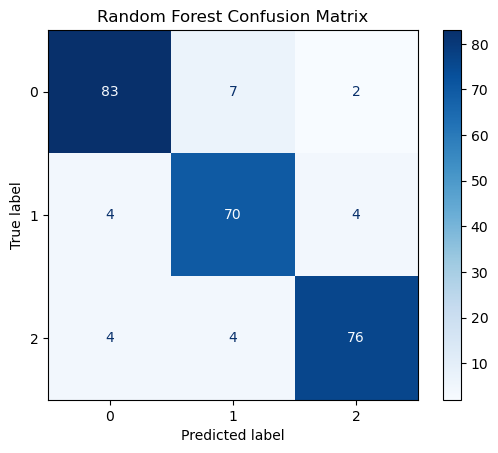

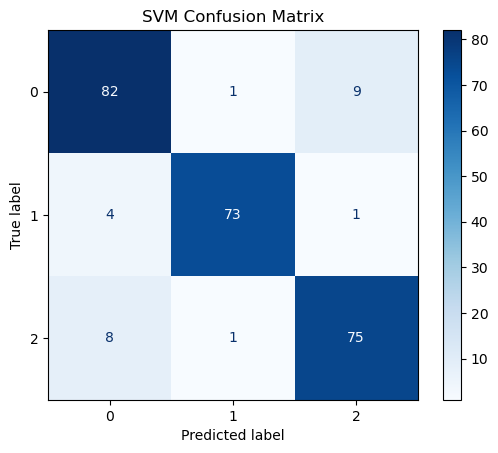

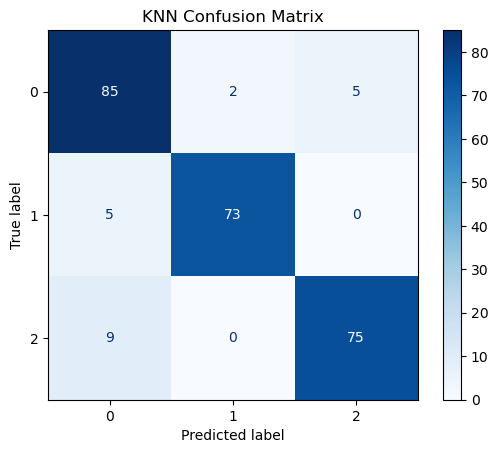

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# confusion matrix Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# confusion matrix SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# confusion matrix KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")